In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [30]:
# read data
data = pd.read_csv('HousingData.csv')
target = 'MEDV'

In [3]:
# print first five rows
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [4]:
# store NA Columns in na_cols
na_cols = data.columns[data.isna().any()].tolist()

In [5]:
# check datatype of columns with missing data
data[na_cols].dtypes

CRIM     float64
ZN       float64
INDUS    float64
CHAS     float64
AGE      float64
LSTAT    float64
dtype: object

In [31]:
# a method to fill in mean for numerical columns' missing data
def fill_na(df, na):
    for i in na:
        temp = df[i]
        means = temp.mean()
        temp = temp.fillna(means)
        df[i] = temp
    return df
data_noNA = fill_na(data, na_cols)
# check if the fillna method worked
data_noNA_nacol = data_noNA.columns[data_noNA.isna().any()].tolist()

if len(data_noNA_nacol) == 0:
    print('no na detected')
else:
    print('{} na detected'.format(data_noNA_nacol))

no na detected


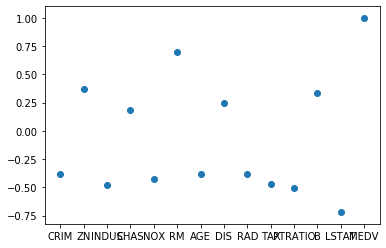

In [32]:
# print correlation between each feature and response variable
plt.scatter(x=data_noNA.columns.tolist(), y=data_noNA.corr()[target][:])

In [56]:
# split x and y
# fit model with all features
x = data_noNA[[i for i in data_noNA.columns.tolist() if i != target]]
y = data_noNA[target]
model = sm.OLS(y,x)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              872.2
Date:                Thu, 19 Sep 2019   Prob (F-statistic):                        0.00
Time:                        22:47:45   Log-Likelihood:                         -1529.0
No. Observations:                 506   AIC:                                      3084.
Df Residuals:                     493   BIC:                                      3139.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0953      0.034     -2.779      0.006      -0.163      -0.028
ZN             0.0452      0.014      3.143      0.002       0.017       0.074
INDUS         -0.0468      0.064     -0.735      0.463      -0.172       0.078
CHAS           3.1345      0.924      3.392      0.001       1.319       4.950
NOX           -2.9625      3.318     -0.893      0.372      -9.481       3.556
RM             6.0518      0.307     19.714      0.000       5.449       6.655
AGE           -0.0159      0.013     -1.176      0.240      -0.042       0.011
DIS           -1.0043      0.192     -5.237      0.000      -1.381      -0.628
RAD            0.1499      0.067      2.227      0.026       0.018       0.282
TAX           -0.0083      0.004     -2.110      0.035      -0.016      -0.001
PTRATIO       -0.4017      0.112     -3.600      0.000      -0.621      -0.182
B              0.0147      0.003      5.381      0.000       0.009       0.020
LSTAT         -0.3724      0.050     -7.452      0.000      -0.471      -0.274
==============================================================================
Omnibus:                      209.147   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1461.565
Skew:                           1.644   Prob(JB):                         0.00
Kurtosis:                      10.649   Cond. No.                     8.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
# store statistics of the original model
original_aic = results.aic
original_bic = results.bic
original_rsqr = results.rsquared_adj
print(original_aic,original_bic,original_rsqr)

3084.0411849764632 3138.9861616772005 0.9572354030072374


In [161]:
# drop feature recursively
# using aic as performance measure

def eliminate_feature_aic(x, y, original_aic):
    summary = {}
    print(x.shape)
    for i in x.columns.tolist():
        x_temp = x[[k for k in x.columns.tolist() if k != i]]
        model_temp = sm.OLS(y,x_temp)
        results_temp = model_temp.fit()
        temp_aic = results_temp.aic
        summary[i] = temp_aic
    minimum = original_aic
    for i in summary.keys():
        aic = summary[i]
        if aic < minimum:
            minimum = aic
            min_feature = i
    try:
        print('min aic is when dropping {} resulting aic {}'.format(min_feature, minimum))
    except:
        print('loop ended, min aic reached')
        return x
    x = x[[k for k in x.columns.tolist() if k != min_feature]]
    if len(x.columns.tolist()) <= 10:
        return x
    
    original_aic = minimum
    return eliminate_feature_aic(x, y, original_aic)


new_x = eliminate_feature_aic(x, y, original_aic)
print('new data shape is {}'.format(new_x.shape))

(506, 13)
min aic is when dropping INDUS resulting aic 3082.59543235594
(506, 12)
min aic is when dropping NOX resulting aic 3081.858144435004
(506, 11)
loop ended, min aic reached
new data shape is (506, 11)


In [129]:
# drop feature recursively
# using bic as performance measure

def eliminate_feature_bic(x, y, original_bic):
    summary = {}
    for i in x.columns.tolist():
        x_temp = x[[k for k in x.columns.tolist() if k != i]]
        model_temp = sm.OLS(y,x_temp)
        results_temp = model_temp.fit()
        temp_bic = results_temp.bic
        summary[i] = temp_bic
    minimum = original_bic
    for i in summary.keys():
        bic = summary[i]
        if bic < minimum:
            minimum = bic
            min_feature = i
    try:
        print('min aic is when dropping {} resulting {}'.format(min_feature, minimum))
    except:
        print('loop ended, min bic reached')
        return x
    x = x[[k for k in x.columns.tolist() if k != min_feature]]
    if len(x.columns.tolist()) <= 10:
        return x
    
    original_bic = minimum
    return eliminate_feature_bic(x, y, original_bic)


new_x = eliminate_feature_bic(x, y, original_bic)
print('new data shape is {}'.format(new_x.shape))

min aic is when dropping INDUS resulting 3133.3138723873894
min aic is when dropping NOX resulting 3128.350047797166
min aic is when dropping AGE resulting 3124.5497229731527
new data shape is (506, 10)


In [130]:
# drop feature recursively
# using adjusted r-squared as performance measure

def eliminate_feature_rs(x, y,original_rsqr):
    summary = {}
    for i in x.columns.tolist():
        x_temp = x[[k for k in x.columns.tolist() if k != i]]
        model_temp = sm.OLS(y,x_temp)
        results_temp = model_temp.fit()
        temp_rsqr = results_temp.rsquared_adj
        summary[i] = temp_rsqr
        
    maximum = original_rsqr
    for i in summary.keys():
        r_sqr = summary[i]
        if r_sqr > maximum:
            maximum = r_sqr
            max_feature = i
    try:
        print('highest rsquare-adj is when dropping {} resulting {}'.format(max_feature, maximum))
    except:
        print('loop ended, reached highest adjusted r-square')
        return x
    
    x = x[[k for k in x.columns.tolist() if k != max_feature]]
    if len(x.columns.tolist()) <= 10:
        return x
    original_rsqr = maximum
    return eliminate_feature_rs(x, y, original_rsqr)


new_x = eliminate_feature_rs(x, y,original_rsqr)
print('new data shape is {}'.format(new_x.shape))

highest rsquare-adj is when dropping INDUS resulting 0.9572751980029789
loop ended, reached highest adjusted r-square
new data shape is (506, 12)
